# Chainer
**『ゼロから作る Deep Learning』を一通り理解していることを前提に進めます**

neural network のライブラリには、TensorFlow, Keras, DyNet, PyTorch などがあります。今回は Chainer を使います。もちろん、他のライブラリの使用をさまたげるものではありません。

自然言語処理では単語系列のように入力の長さが可変のデータを扱うことが多く、ネットワークの構造が事前に決まらないという特性があります。Chainer の define-by-run という設計方針はこの特性を扱うのに適しています。

一方、Chainer の利用者の多くは日本におり、公開されている既存手法が PyTorch や TensorFlow で実装されていることが少なくないという欠点もあります。

Chainer は CPU と GPU のいずれでも動作します。プログラミングは CPU を使って行い、大規模データでの実験は GPU で行うのが良いでしょう。

Chainer のインストールは以下のコマンドで行います。

```
pip install chainer
```

CUDA のセットアップに失敗している場合でもインストールに成功してしまいます。GPU のある環境で、環境変数 CUDA_PATH 等を整えた状態でインストールする必要があります。virtualenv を使って、CPU のみの通常のサーバと GPU マシンで別の環境を整えることを勧めます。

ニューラルネットのモデルを作るには少なくとも以下の機能が必要です

1. ニューラルネットの各ユニット (Link と Parameter)
2. ユニットを束ねて管理するモデル (Chain, ChainList)
3. forward/backward 計算機能 (Function) とその入出力たる変数 (Variable)
4. backward 計算の結果を用いたニューラルネットのパラメータの更新 (optimizers)
5. 訓練・テストデータの読み込み (datasets, iterators)
6. モデルの保存・ロード (serializers)

括弧内が Chainer が提供する class やモジュールです。

まず重要なのは forward/backward 計算を隠蔽する Variable です。Variable は numpy (cupy) の多次元配列をラップしたものです。まずは numpy について軽く復習し、次に Variable の機能を見ます。

## numpy
neural network で処理されるデータは通常、多次元配列で表現されます。Chainer は CPU では numpy を、GPU では cupy を使います。cupy は CUDA (GPU) 上で多次元配列を扱うためのライブラリで、numpy と同様のインターフェースを提供します。

まず numpy を import します。慣習的に np という名前をつけます。

In [1]:
import numpy as np

(import numpy as np を import cupy as np とすると、ほとんどの場合、そのまま GPU で動作します)

Chainer では主に単精度の np.float32 型のデータを扱います。他に np.int32 と np.bool_ を使うこともあります。

In [2]:
# 2次元配列の作成
mat = np.array([[0.1, 0.2, 0.3],[0.2, 0.4, 0.6]], dtype=np.float32)
mat

array([[0.1, 0.2, 0.3],
       [0.2, 0.4, 0.6]], dtype=float32)

In [3]:
mat.size

6

In [4]:
mat.shape

(2, 3)

In [5]:
# すべての要素に 2.0 を足します
v = np.array([0.5, -0.2, 1.9], dtype=np.float32)
v + 2.0

array([2.5, 1.8, 3.9], dtype=float32)

In [6]:
# 演算結果は新たな配列に格納されています
v2 = v
v = v * 2
(v, v2)

(array([ 1. , -0.4,  3.8], dtype=float32),
 array([ 0.5, -0.2,  1.9], dtype=float32))

In [7]:
# もとの配列に結果を格納したい場合は Ellipsis を使います
v = np.array([0.5, -0.2, 1.9], dtype=np.float32)
v2 = v
v[...] = v * 2
(v, v2)

(array([ 1. , -0.4,  3.8], dtype=float32),
 array([ 1. , -0.4,  3.8], dtype=float32))

In [8]:
# 演算子が用意されていない演算は np.FOO という関数で提供されています
# よく使うのは log, exp などです
v = np.array([0.5, -0.2, 1.9], dtype=np.float32)
np.exp(v)

array([1.6487212, 0.8187308, 6.6858945], dtype=float32)

In [9]:
# 同じ shape の配列同士の四則演算は element-wise です
v1 = np.array([0.5, -0.2, 1.9], dtype=np.float32)
v2 = np.array([1.0, 0.8, -1.9], dtype=np.float32)
v1 + v2

array([1.5, 0.6, 0. ], dtype=float32)

In [10]:
# 論理演算も element-wise です
v = np.array([0.5, -0.2, 1.9], dtype=np.float32)
v > 0.0

array([ True, False,  True])

In [11]:
# sum, max, min
v = np.array([0.5, -0.2, 1.9], dtype=np.float32)
v.sum(), v.max(), v.min()

(2.2, 1.9, -0.2)

In [12]:
# 次元を指定して集約を行います
mat = np.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]], dtype=np.float32)
mat.sum(axis=0), mat.sum(axis=1)

(array([5., 7., 9.], dtype=float32), array([ 6., 15.], dtype=float32))

In [13]:
# 論理演算と sum の組み合わせ
v = np.array([0.5, -0.2, 1.9, 2.6, 5.5, 9.2, 3.3], dtype=np.float32)
(v > 4.0).sum()

2

## Chainer の Variable

最初にモジュール一式を import します。

In [14]:
# chainer 4.0 準拠なので古いバージョンではエラーが出るかも
import numpy as np
import chainer
from chainer.backends import cuda
from chainer import Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer import reporter
from chainer.training import extensions

In [15]:
# Variable は numpy/cupy の配列を受けとります
x = Variable(np.array([2.0, 3.0, 6.0], dtype=np.float32))
x

variable([2., 3., 6.])

In [16]:
# 実際の配列は x.data に格納されています
x.data

array([2., 3., 6.], dtype=float32)

In [17]:
# 算術演算やその他の演算が Chainer 上で実装されています
# 演算子以外は np.FOO の代わりに F.FOO が用意されています (例えば、F.log() )
y = x**2 - 2 * x - 1
y, y.data

(variable([-1.,  2., 23.]), array([-1.,  2., 23.], dtype=float32))

y も Variable オブジェクトなのが確認できます。Variable オブジェクトは、配列データに加えて、forward/backward 計算に必要な計算グラフを保持しています。

演算子 \*\*, \*, \+ などは、Chainer がオーバーロードしています。内部で適切な Function クラスの forward() メソッドが呼び出されています。

In [18]:
z = Variable(np.array([2.0, 3.0, 23.0], dtype=np.float32)) # 正解データ
loss = F.mean_squared_error(y, z) # 2乗誤差
loss.data

array(3.3333333, dtype=float32)

In [19]:
# backward() を呼び出すと backprop が行われます
# 内部で適切な Function クラスの backward() メソッドが呼び出されています
loss.backward()

In [20]:
# 自動微分の結果が grad に格納されています。y が正解 z に近づくように x を更新するための勾配です。
x.grad

array([-4.       , -2.6666665,  0.       ], dtype=float32)

Variable を自分で作るのは、原則的にネットワークの入力データと正解データだけです (ネットワーク内の定数パラメータを除く)。データを操作する際は、必ず Chainer が提供する機能を用いなければなりません (もしくは自分で Function のサブクラスを作り、forward(), backward() を実装する必要があります)。

初心者がやりがちなミスですが、forward 計算の途中で、data を取り出し、自分で何らかの操作を行った上で、その結果を Variable オブジェクトに格納するといった操作を**行ってはなりません**。計算グラフが途切れてしまい、backprop が正しく行われなくなります。

## モデルの定義

ここでは、シンプルな3層パーセプトロンを定義します。これは全結合層のみからなるネットワークです。中間層のユニット数は適当に100とし、出力は10クラスなので10とします。ここで用いるMNISTデータセットは10種のラベルを持つためです。では、モデルを定義するために必要なLink, Function, そしてChainについて、簡単にここで説明を行います。

### LinkとFunction

* Function はパラメータを持たない関数で、forward(), backward() を提供します
* Link は更新すべきパラメータを保持し、\__call\__() を提供します
* これらを組み合わせて計算を記述します
* パラメータを持つ層は、chainer.linksモジュール以下にたくさん用意されています
* パラメータを持たない層は、chainer.functionsモジュール以下にたくさん用意されています
* これらを簡単に使うために、

    ```
    import chainer.links as L
    import chainer.functions as F
    ```
    と別名を与えて、L.Convolution2D(...)やF.relu(...)のように用いる慣習があります。

### Chain

* Chain は、パラメータを持つ層＝Linkを束ねるためのクラスです。
* パラメータを持つということは、基本的にモデルの学習の際にそれらを更新していく必要があるということです。
* そこで、学習中に Optimizer が更新すべき全てのパラメータを簡単に取得できるように、Chain で一箇所にまとめておきます。

### Chainを継承して定義されるモデル

* モデルは Chain クラスを継承したクラスとして定義されます
* その場合、モデルを表すクラスのコンストラクタで、親クラスのコンストラクタにキーワード引数の形で登録したい層の名前と、オブジェクトを渡しておくと、自動的にOptimizerから見つけられる形で保持しておいてくれます。
* これは、別の場所でadd_linkメソッドを使っても行うことができます。
* また、関数呼び出しのようにしてモデルに ()アクセサでデータを渡せるように、\__call\__メソッドを定義して、その中にforward処理を記述すると便利です。

In [21]:
class MLP(chainer.Chain):
    def __init__(self, n_mid_units=100, n_out=10):
        # お約束
        super(MLP, self).__init__()
        # パラメータを持つ層の登録を with scope 以下で行う
        with self.init_scope():
            # Linear は W x + b の線形変換 (全結合) を行うLink
            # 第1引数は入力の次元数 (Noneの場合は、初回呼び出し時にデータから自動的に推測)
            # 第2引数は出力の次元数
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(None, n_mid_units)
            self.l3 = L.Linear(None, n_out)

    def __call__(self, x, t):
        # __call__ は損失を返すようにしておく
        y = self.predict(x)
        loss = F.softmax_cross_entropy(y, t)

        # あとで使う
        reporter.report({'loss': loss.data}, self)
        return loss

    def predict(self, x):
        # データを受け取った際のforward計算を書く
        # relu は Rectified Linear Unit: f(x)=max(0,x)
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

# インスタンスを作成
model = MLP()

## GPU で計算する場合
# model.to_gpu(gpu_id)

ここで、L.Linearクラスは全結合層を意味します。コンストラクタの第一引数にNoneを渡すと、実行時に、データがその層に入力された瞬間、必要な数の入力側ユニット数を自動的に計算し、(n_input) $\times$ n_mid_unitsの大きさの行列を作成し、パラメータとして保持します。これは後々、畳み込み層を全結合層の前に配置する際などに便利な機能です。

前述のように、Linkはパラメータを持つので、そのパラメータの値にアクセスすることができます。例えば、上のモデルMLPはl1という名前の全結合層が登録されています。この全結合層はWとbという2つのパラメータを持ちます。

In [22]:
print('1つ目の全結合相のバイアスパラメータの形は、', model.l1.b.data.shape)
print('初期化直後のその値は、', model.l1.b.data)

1つ目の全結合相のバイアスパラメータの形は、 (100,)
初期化直後のその値は、 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


## データセットの準備

では、実際にデータセットを使ってモデルを訓練してみます。ニューラルネットもパラメータを $\theta$ とすると、入力 $x$ と出力 $y$ のペアを与えたとき、$y = f(x; \theta)$ となる (に近づく) ようにパラメータ $\theta$ を更新します。

今回は手描き数値認識データセット MNIST を使います。入力は数値の画像、出力は0-9のいずれかです。

データの入手には Chainer が用意しているメソッドを利用します。このメソッドはデータのダウンロードし、一つ一つのデータを取り出してくれます。

自分が解きたい問題に対しては、同様の処理を自分で用意する必要があります。


In [23]:
from chainer.datasets import mnist

# データセットがダウンロード済みでなければ、ダウンロードも行う
train, test = mnist.get_mnist(withlabel=True, ndim=1)

# データセットの事例数
# ここでは訓練データ (train)、テストデータ (test) の2個だけです
# 以下では、test を開発データとして使うので注意が必要です
len(train), len(test)

(60000, 10000)

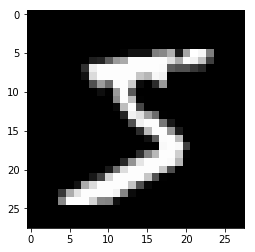

label: 5


In [24]:
# matplotlibを使ったグラフ描画結果がnotebook内に表示されるようにします。
%matplotlib inline
import matplotlib.pyplot as plt

x, t = train[0] # 1個の事例
# 入力は 784 (28x28) 個の要素からなる実数列、出力は 0-9 のいずれかのラベル
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

データセットはIteratorクラスのオブジェクトに与えます。Iteratorは、next()を呼び出すごとに、データセットから指定されたサイズのミニバッチを作って返します。内部ではデータセットを何周なめたか（epoch）、現在のイテレーションが新しいepochの最初のイテレーションか、などを管理するプロパティ（is_new_epoch）などを持っています。

In [25]:
batchsize = 128 # minibatchのサイズ

# デフォルトでデータセット内の事例をshuffleする
train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize,
                                     repeat=False, shuffle=False)

## 最適化手法の選択

Chainerは多くの最適化手法を提供しています。chainer.optimizersモジュール以下にそれらはあります。ここではもっともシンプルな勾配降下法の手法であるoptimizers.SGDを用います。Optimizerのオブジェクトには、setupメソッドを使ってモデル（Chainオブジェクト）を渡します。こうすることでOptimizerは、自身が更新すべきモデル内のパラメータを自動的にたどってくれます。

他にもいろいろな最適化手法が手軽に試せるので、色々と試してみて結果の変化を見てみてください。例えば、下のchainer.optimizers.SGDのうちSGDの部分をMomentumSGD, RMSprop, Adamなどに変えて、結果の違いを見てみましょう。

In [26]:
optimizer = optimizers.SGD(lr=0.01)
optimizer.setup(model)

今回はSGDのコンストラクタのlrという引数に $0.01$ を与えました。この値は学習率として知られ、モデルをうまく訓練して良いパフォーマンスを発揮させるために調整する必要がある重要なハイパーパラメータとして知られています。

## 学習ループ

いよいよ学習ループです。今回は分類問題なので、softmax_cross_entropyという損失関数を使って最小化すべき損失 (loss) の値を計算します。

Chainerでは、FunctionやLinkを使ってモデルのforward計算を行い、結果と正解ラベルをFunctionの一種でありスカラ値を返す損失関数に渡してやり、損失の計算を行うと、それは他のLinkやFunctionと同じく、Variableオブジェクトを返します。Variableオブジェクトはこれまでの計算過程をあとから逆向きにたどるための参照を保持しているため、Variable.backwardメソッドを呼ぶだけで、自動的にそこからこれまでの計算過程をさかのぼって、途中で施された計算に用いられたパラメータの勾配を計算してくれます。

つまり、学習ループの1回の中で行うのは、以下の4項目です。

1. モデルにデータを渡して出力yを得る
2. yと正解ラベルtを使って、最小化すべき損失の値をsoftmax_cross_entropy関数で計算する
3. softmax_cross_entropy関数の出力Variableのbackwardメソッドを呼んで、モデル内部のパラメータにgradプロパティ（これがパラメータ更新に使われる勾配）を持たせる
4. Optimizerのupdateメソッドを呼び、3.で計算したgradを使って全パラメータを更新する

以上です。では実際に訓練ループを書いていきます。

In [27]:
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu

gpu_id = -1
max_epoch = 10

while train_iter.epoch < max_epoch:
    
    # ---------- 学習の1 epoch ----------
    train_batch = train_iter.next()
    # minibatch の事例列を連結して配列にします
    x, t = concat_examples(train_batch, device=gpu_id)
    x = Variable(x) # (128, 784)
    t = Variable(t) # (128,)
    
    # 損失の計算
    loss = model(x, t) # (128, 10), (128,)

    # 勾配の計算
    model.cleargrads()
    loss.backward()

    # パラメータの更新
    optimizer.update()
    # --------------- ここまで ----------------

    # 1エポック終了ごとにValidationデータに対する予測精度を測って、
    # モデルの汎化性能が向上していることをチェックしよう
    if train_iter.is_new_epoch:  # 1 epochが終わったら

        # 損失の表示
        print('epoch:{:02d} train_loss:{:.04f} '.format(
            train_iter.epoch, float(to_cpu(loss.data))), end='')

        test_losses = []
        test_accuracies = []
        while True:
            test_batch = test_iter.next()
            x_test, t_test = concat_examples(test_batch)

            # テストデータをforward
            y_test = model.predict(x_test)

            # 損失を計算
            loss_test = F.softmax_cross_entropy(y_test, t_test)
            test_losses.append(to_cpu(loss_test.data))

            # 精度を計算
            accuracy = F.accuracy(y_test, t_test)
            accuracy.to_cpu()
            test_accuracies.append(accuracy.data)
            
            if test_iter.is_new_epoch:
                test_iter.epoch = 0
                test_iter.current_position = 0
                test_iter.is_new_epoch = False
                test_iter._pushed_position = None
                break

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
            np.mean(test_losses), np.mean(test_accuracies)))

epoch:01 train_loss:0.8590 val_loss:0.8088 val_accuracy:0.8093
epoch:02 train_loss:0.3633 val_loss:0.4702 val_accuracy:0.8749
epoch:03 train_loss:0.3196 val_loss:0.3812 val_accuracy:0.8946
epoch:04 train_loss:0.4340 val_loss:0.3413 val_accuracy:0.9052
epoch:05 train_loss:0.2313 val_loss:0.3156 val_accuracy:0.9115
epoch:06 train_loss:0.3901 val_loss:0.2982 val_accuracy:0.9166
epoch:07 train_loss:0.3309 val_loss:0.2860 val_accuracy:0.9180
epoch:08 train_loss:0.3479 val_loss:0.2735 val_accuracy:0.9225
epoch:09 train_loss:0.2730 val_loss:0.2612 val_accuracy:0.9264
epoch:10 train_loss:0.1551 val_loss:0.2517 val_accuracy:0.9291


In [28]:
# 学習結果のモデルをファイルに保存
serializers.save_npz('my_mnist.model', model)

# ちゃんと保存されていることを確認
%ls -la my_mnist.model

-rw-r--r-- 1 murawaki user 333945  5月 15 12:11 my_mnist.model


今しがた保存したモデルを読み込んで、テストデータに対して予測を計算させてみます。モデルのオブジェクトをまず作成し、そのパラメータを先程保存したモデルが持つ値で上書きすることで学習直後のモデルの状態を復元します。

In [29]:
# まず同じモデルのオブジェクトを作る
infer_model = MLP()

# そのオブジェクトに保存済みパラメータをロードする
serializers.load_npz('my_mnist.model', infer_model)

# GPU上で計算させるために、モデルをGPUに送る
# infer_model.to_gpu(gpu_id)

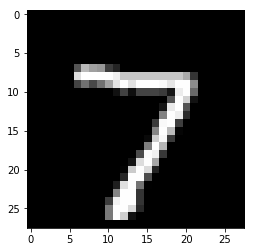

label: 7


In [30]:
# テストデータ
x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

In [31]:
# ミニバッチの形にする（ここではサイズ1のミニバッチにするが、
# 複数まとめてサイズnのミニバッチにしてまとめて推論することもできる）
print(x.shape, end=' -> ')
x = x[None, ...]
print(x.shape)

# モデルのforward関数に渡す
y = infer_model.predict(x)

# Variable形式で出てくるので中身を取り出す
y_data = y.data

# 最大値のインデックスを見る
pred_label = y_data.argmax(axis=1)

print('predicted label:', pred_label[0])

(784,) -> (1, 784)
predicted label: 7


## Trainer の使用

上記の訓練用コードは比較的低レベルのコードを呼び出していましたが、Chainer はそれらを隠蔽する機能を提供しています。

In [32]:
# train_iter, test_iter, model, optimizer を作り直す
train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize,
                                     repeat=False, shuffle=False)
model = MLP()
optimizer = optimizers.SGD(lr=0.01)
optimizer.setup(model)


# 0 以上なら指定された ID の GPU を使用
gpu_id = -1

# train_iter から一回ずつ minibatch を作り、model の __call__() を呼び、損失を計算し、optimizer を使ってパラメータを更新する機能を提供
updater = training.updaters.StandardUpdater(train_iter, optimizer, converter=concat_examples, device=gpu_id)

# 訓練 epoch 数
max_epoch = 10
# out はモデル一式を出力するディレクトリ
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='mnist_result')

#
# Trainer は様々な utility で extend できる
#

# 1 epoch ごとにテストデータで loss を計算
trainer.extend(extensions.LogReport())
evaluator = extensions.Evaluator(test_iter, model, converter=concat_examples, device=gpu_id)
trainer.extend(evaluator, trigger=(1, 'epoch'))

# 1 epoch ごとに現状を print
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss']), trigger=(1, 'epoch'))

# 結果を保存
trainer.extend(extensions.snapshot(), trigger=(10, 'epoch'))
 
# いよいよ実行
trainer.run()

# 結果を確認
%ls -la mnist_result

epoch       main/loss   validation/main/loss
1           1.4589      0.721039              
2           0.564639    0.438967              
3           0.417931    0.365231              
4           0.364078    0.329656              
5           0.334119    0.308182              
6           0.313114    0.289609              
7           0.297122    0.279543              
8           0.282826    0.264874              
9           0.271177    0.255754              
10          0.260479    0.24732               
total 968
drwxr-xr-x 2 murawaki user     41  5月 15 12:11 ./
drwxr-xr-x 5 murawaki user   4096  5月 15 12:09 ../
-rw------- 1 murawaki user   1966  5月 15 12:11 log
-rw-r--r-- 1 murawaki user 512782  5月 15 12:11 snapshot_iter_4688


## GPU の使用

Chainer はコードをほとんど変更することなく CPU から GPU に移行できるように設計されています。

GPU は独自のメモリを持っており、処理対象となる配列をこのメモリに載せる必要があります。必要な作業は主に以下の2つです

1. モデルを GPU にロードする
2. データを GPU にロードする

モデルのロードは以下のコードで行なえます

In [33]:
gpu_id = -1

if gpu_id >= 0:
    # 指定された GPU を現在の GPU に
    chainer.backends.cuda.get_device_from_id(gpu_id).use()
    ## 以前のバージョンでは以下のように指定
    # cuda.check_cuda_available()
    # cuda.get_device(gpu_id).use()

    # モデルを GPU に転送
    model.to_gpu()

データは一般に量が多いので、訓練時に毎回 GPU にロードします


```
cupy_array = cuda.to_gpu(numpy_array)
```
で numpy の配列を現在利用中の CUDA デバイス (GPU カード) にコピーします。逆に cupy 配列から numpy 配列を得るには
```
numpy_array = cuda.to_cpu(cupy_array)
```
とします。

上記の model.to_gpu() では内部で cuda.to_gpu() が呼び出されます。

StandardUpdater と Evaluator に device=gpu_id というオプションが指定されていました。Chainer が提供するこれらのモジュールも、内部で cuda.to_gpu() を呼び出してデータを GPU に転送しています。

GPU を使用するには、空いている GPU を見つける必要があります。nvidia-smi というコマンドで GPU の使用状況が確認できます。

## シンボルの処理

MNIST は画像であり入力は連続値でした。自然言語処理では単語のようなシンボルが頻繁に現れます。連続値を処理するニューラルネットにシンボルを扱わせるには、入力時と出力時に適切な変換が必要となります。

入力時には単語を実数ベクトルに変換します。このためにまずは単語を ID に変換します。あらかじめ語彙サイズ (単語の異なり数, 次元) を決め、前処理によって (主に頻度順ソートにより) 単語に ID を与えます。この際、UNK という特殊な単語を用意して、残りの単語を UNK に変換します。

In [34]:
# 前処理済み Penn Treebank 
train, val, test = chainer.datasets.get_ptb_words()

# 語彙サイズ
n_vocab = max(train) + 1

# 単語列が ID 列に変換されている
print(train[0:100])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 27 24 39 26 40 41 42 26 43
 32 44 45 46 24 47 26 27 28 29 48 49 41 42 50 51 52 53 54 55 35 36 37 42
 56 57 58 59 24 35 60 42 61 62 63 64 65 66 67 68 69 70 35 71 72 42 73 74
 75 35 46 42]


EmbedID は単語IDをベクトルに変換するためのパラメータを保持しています

In [35]:
wdims = 100 # 単語ベクトルの次元数
voc = L.EmbedID(n_vocab, wdims, ignore_label=-1)

# 長さ3で揃った文が4個
# T は転置 (transpose)
# 時刻ごとに minibatch を作るので転置
# 文の長さが不揃いの場合はひと手間必要
seq = Variable(np.array([[12, 10, 5], [4, 3, 99], [2, 1, 4], [4, 22, 0]], dtype=np.int32).T)
sentlen, batchsize = seq.data.shape

# 0番目の minibatch
print(seq.data[0])

# EmbedID でベクトルに変換
x = voc(seq)
print(x.data.shape) # (sentlen, batchsize, wdims)


[12  4  2  4]
(3, 4, 100)


出力を考えるために、まず recurrent neural network (RNN) を導入します。

RNN 1回の処理は次のとおりです。

$h_t = \sigma(W x_t + U h_{t-1} + b)$

これを実装します。

In [36]:
hdims = 50  # 隠れ状態の次元数

W = L.Linear(wdims, hdims, nobias=True)
U = L.Linear(hdims, hdims) # b は U に含まれる

def apply_rnn(x, h):
    return F.tanh(W(x) + U(h))

In [37]:
xs = F.split_axis(x, sentlen, 0)
print(len(xs)) # 3
print(xs[0].data.shape) # (1, batchsize, wdims)


# 隠れ状態の初期値は 0 ベクトルを使う場合と、パラメータとして訓練する場合があります
# ここではパラメータを用意します
h_init = Variable(np.zeros(hdims, dtype=np.float32))

# 使う際には batchsize 分だけ broadcast する必要
h_init2 = F.broadcast_to(F.reshape(h_init, (1, hdims)), (batchsize, hdims))
print(h_init2.data.shape) # (batchsize, hdims)


# time=0 での更新
x0 = F.reshape(xs[0], (batchsize, wdims))
h0 = apply_rnn(x0, h_init2)
print(h0.data.shape) # (batchsize, hdims)

# 同様に h1 を計算
x1 = F.reshape(xs[1], (batchsize, wdims))
h1 = apply_rnn(x1, h0)

# h2 を計算
# もちろんこのような繰り返し計算は本来 for ループで記述すべきものです
x2 = F.reshape(xs[2], (batchsize, wdims))
h2 = apply_rnn(x2, h1)

3
(1, 4, 100)
(4, 50)
(4, 50)


準備ができたので出力について考えます。

RNN 言語モデルはある時点での隠れ状態をもとに次の単語を予測します。単語の候補数は語彙サイズです。各単語にスコアを与えるすると、(minibatch x) 語彙サイズの配列が必要になります。これは Linear で簡単に実現できます。

スコアが大きいほどもっともらしいとします。softmax 関数を用いれば確率値に変換できます。また、正解の単語が与えられたとき、softmax cross entropy を損失関数として最適化すれば、正しい単語を予測するようにモデルが訓練されます。

In [38]:
# 隠れ状態から n_vocab 個ある単語のスコアを計算
h2y = L.Linear(hdims, n_vocab)

def predict(h):
    return h2y(h)

In [39]:
y1 = predict(h0)

print(y1.data.shape) # (batchsize, n_vocab)

seqs = F.split_axis(seq, sentlen, 0)

# y1 が  seqs[1] の予想としてどの程度良いか (小さいほど良い)
seq1 = F.reshape(seqs[1], (batchsize,))
loss1 = F.softmax_cross_entropy(y1, seq[1])
print(loss1.data)

(4, 10000)
9.436229


In [40]:
y2 = predict(h1)
seq2 = F.reshape(seqs[2], (batchsize,))
loss2 = F.softmax_cross_entropy(y2, seq2)

y3 = predict(h2)
eos_id = 9999 # <EOS> の ID; vocabulary の中に <EOS> が入っている必要があります
seq3 = Variable(eos_id * np.ones(batchsize, dtype=np.int32))
loss3 = F.softmax_cross_entropy(y3, seq3)

# ここまでの計算も for ループ化できます
loss = loss1 + loss2 + loss3
# 初期設定を適切に行ったうえで loss.backward() をよびだせば勾配が得られます